# Peyton Manning
---
## Introduction

Peyton Manning is a former football player, and his [Wikipedia page](https://en.wikipedia.org/wiki/Peyton_Manning)'s data represents a complex time series: contains seazonal behaviour, different growth rates and random days with a higher number of visualizations. Is it possible to forecast the number of visualizations in his Wikipedia page? That's what I'll find out, using ARIMA and Prophet, as you can see below: 

---
## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

---
## Loading databases, and data visualization 

In [2]:
dataset = pd.read_csv('page_wikipedia.csv')
dataset.head()

date     views
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

The number of views is likely in thousands, at least. 

To apply the ARIMA method, it's necessary to set the month column as the index. 

In [3]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
time_series = pd.read_csv('page_wikipedia.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
time_series.head()

views
date                
2007-12-10  9.590761
2007-12-11  8.519590
2007-12-12  8.183677
2007-12-13  8.072467
2007-12-14  7.893572

In [4]:
time_series.index.max()

Timestamp('2016-01-20 00:00:00')

In [5]:
time_series.index.min()

Timestamp('2007-12-10 00:00:00')

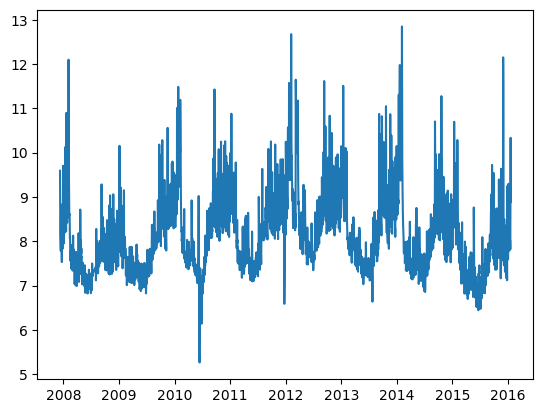

In [6]:
plt.plot(time_series)

The chart above shows a probable seasonal pattern.

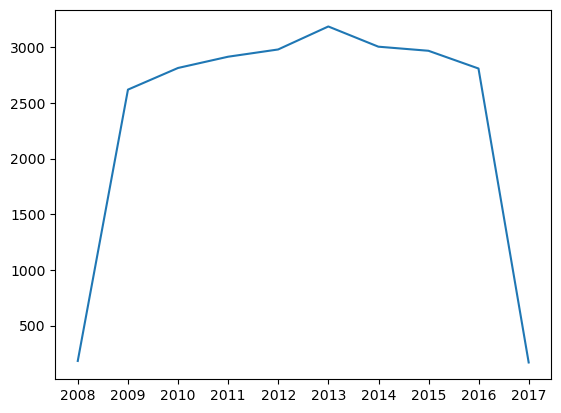

In [7]:
time_series_ano = time_series.resample('A').sum()
plt.plot(time_series_ano)

It seems like there was an upward trend, but it started to fall after 2012.

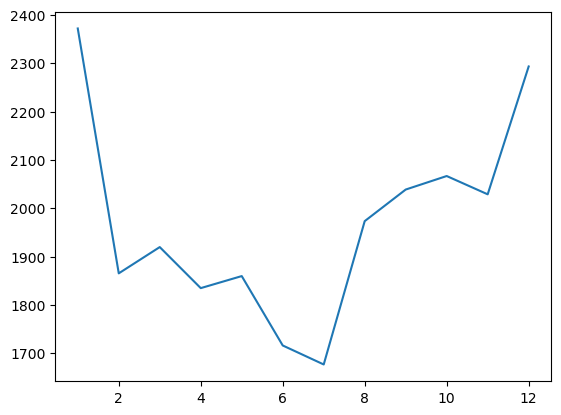

In [8]:
time_series_month = time_series.groupby([lambda x: x.month]).sum()
plt.plot(time_series_month)

So far, it's not possible to see a pattern.

---
## Decomposition of Time Series

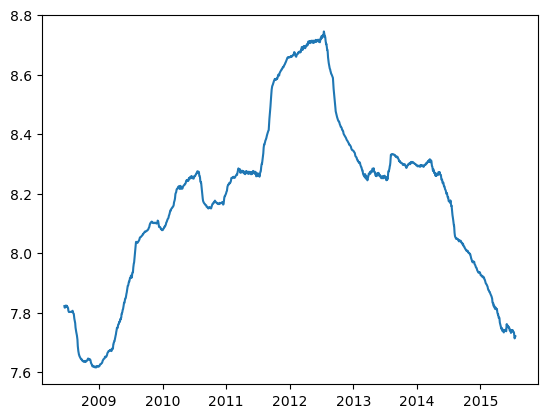

In [9]:
decomposition = seasonal_decompose(time_series, period=365)
trend = decomposition.trend
plt.plot(trend)

The chart above confirms the irregular upward trend until 2012, followed by a downward trend.

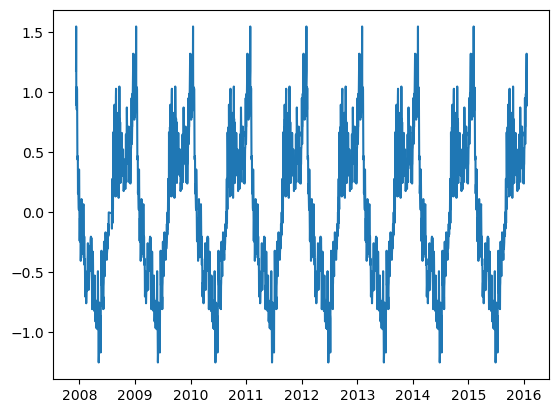

In [10]:
seasonal = decomposition.seasonal
plt.plot(seasonal)

The chart above confirms the seasonal pattern. 

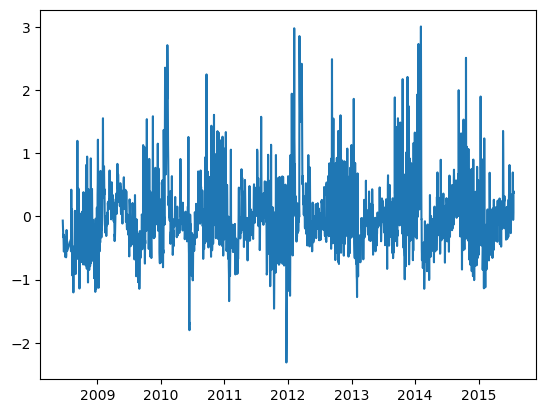

In [11]:
residual = decomposition.resid
plt.plot(residual)

The chart above suggest that there might have been an unusual event that changed the patterns in 2012.

---
## Modeling - ARIMA

### Fiding the parameters

In [12]:
model = auto_arima(time_series)
model.order

(2, 1, 1)

The best P, Q and D patameters found were 2, 1 and 1. Which means: 
- P - The model considers 2 previous observations, to forecast the next one;
- D - It's necessary to difference the series once to remove trends or non-constant seasonal patterns over time;
- Q - The model uses the last observation's error, to forecast the next one. 

### Predictions

In [13]:
time_series.index = pd.to_datetime(time_series.index)
time_series = time_series.asfreq('D')
time_series = time_series.interpolate()
decomposition = seasonal_decompose(time_series, period=365)

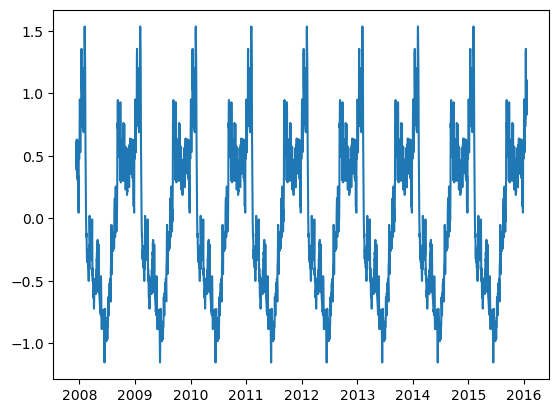

In [14]:
seasonal = decomposition.seasonal
plt.plot(seasonal)

In [15]:
if not isinstance(time_series.index, pd.DatetimeIndex):
    time_series.index = pd.to_datetime(time_series.index)  # Convert to DatetimeIndex if needed

model = auto_arima(time_series)
model_fit = model.fit(y=time_series)

# Predictions for 30 days
predictions = model_fit.predict(n_periods=30)
print(predictions)

2016-01-21    8.753966
2016-01-22    8.734263
2016-01-23    8.755899
2016-01-24    8.772347
2016-01-25    8.776222
2016-01-26    8.774460
2016-01-27    8.772585
2016-01-28    8.771977
2016-01-29    8.772088
2016-01-30    8.772291
2016-01-31    8.772376
2016-02-01    8.772375
2016-02-02    8.772354
2016-02-03    8.772343
2016-02-04    8.772342
2016-02-05    8.772344
2016-02-06    8.772345
2016-02-07    8.772345
2016-02-08    8.772345
2016-02-09    8.772345
2016-02-10    8.772345
2016-02-11    8.772345
2016-02-12    8.772345
2016-02-13    8.772345
2016-02-14    8.772345
2016-02-15    8.772345
2016-02-16    8.772345
2016-02-17    8.772345
2016-02-18    8.772345
2016-02-19    8.772345
Freq: D, dtype: float64


Apparently, the predictions were very similar numbers - after 2016-02-06, they were exactly the same.

---
## Predictions Chart - ARIMA

In [16]:
len(time_series)

2964

In [17]:
train = time_series[:2934]
train.shape

(2934, 1)

Training the model with 2500/2964 records

In [18]:
train.index.min(), train.index.max()

(Timestamp('2007-12-10 00:00:00', freq='D'),
 Timestamp('2015-12-21 00:00:00', freq='D'))

In [19]:
test = time_series[2934:]
test.shape

(30, 1)

Testing the model with 464/2964 records

In [20]:
test.index.min(), test.index.max()

(Timestamp('2015-12-22 00:00:00', freq='D'),
 Timestamp('2016-01-20 00:00:00', freq='D'))

In [21]:
model2 = auto_arima(train)

In [22]:
test.index

DatetimeIndex(['2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31', '2016-01-01', '2016-01-02',
               '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10',
               '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-15', '2016-01-16', '2016-01-17', '2016-01-18',
               '2016-01-19', '2016-01-20'],
              dtype='datetime64[ns]', name='date', freq='D')

### Visualizing

In [23]:
prediction = pd.DataFrame(model2.predict(n_periods=30), index=test.index)
prediction.columns = ['passengers_predictions']
prediction

passengers_predictions
date                              
2015-12-22                8.161734
2015-12-23                7.944948
2015-12-24                7.873969
2015-12-25                7.886192
2015-12-26                7.909383
2015-12-27                7.919076
2015-12-28                7.918905
2015-12-29                7.916548
2015-12-30                7.915313
2015-12-31                7.915195
2016-01-01                7.915420
2016-01-02                7.915569
2016-01-03                7.915597
2016-01-04                7.915578
2016-01-05                7.915560
2016-01-06                7.915556
2016-01-07                7.915557
2016-01-08                7.915559
2016-01-09                7.915560
2016-01-10                7.915560
2016-01-11                7.915560
2016-01-12                7.915559
2016-01-13                7.915559
2016-01-14                7.915559
2016-01-15                7.915559
2016-01-16                7.915559
2016-01-17                7.915559
2016-01-18                7.915559
2016-01-19                7.915559
2016-01-20                7.915559

The same happened here, as the numbers were similar, and the last numbers were identicals. 

In [24]:
test

views
date                 
2015-12-22   8.110427
2015-12-23   7.775276
2015-12-24   7.347300
2015-12-25   7.301822
2015-12-26   7.120444
2015-12-27   8.878776
2015-12-28   9.250618
2015-12-29   9.247925
2015-12-30   8.391403
2015-12-31   8.004700
2016-01-01   7.589336
2016-01-02   7.825245
2016-01-03   8.249314
2016-01-04   9.295141
2016-01-05   8.568266
2016-01-06   8.352554
2016-01-07   8.295798
2016-01-08   8.290293
2016-01-09   7.785721
2016-01-10   8.281724
2016-01-11   8.470730
2016-01-12   8.135054
2016-01-13   8.067149
2016-01-14   8.023552
2016-01-15   8.021913
2016-01-16   7.817223
2016-01-17   9.273878
2016-01-18  10.333775
2016-01-19   9.125871
2016-01-20   8.891374

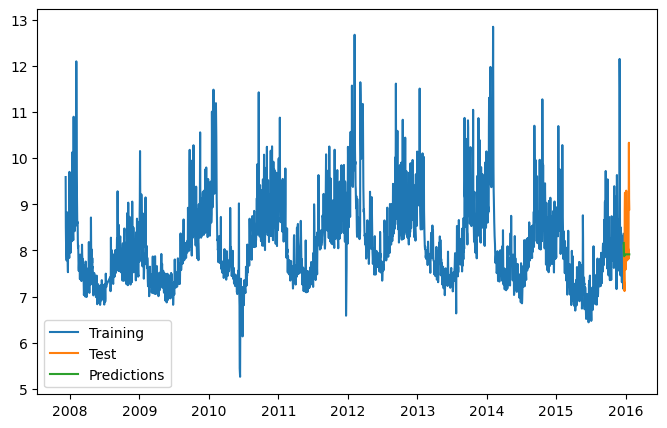

In [25]:
plt.figure(figsize=(8,5))
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.plot(prediction, label = 'Predictions')
plt.legend();

The chart above confirms that the ARIMA model wasn't efficient to predict the number of views, as the predictions were pretty much a horizontal line, while the test data was a lot different. 

### Evaluation Metrics

In [26]:
mae = mean_absolute_error(test, prediction)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(test, prediction)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.5993769897759947
Mean Squared Error (MSE): 0.6559435036311186
Root Mean Squared Error (RMSE): 0.8099033915419287


Even with years of data, the model had a bad accuracy. Trying now Prophet: 

---
## Modeling - Prophet

### Preparing the data

In [27]:
dataset = dataset[['date', 'views']].rename(columns = {'date': 'ds', 'views': 'y'})
dataset

ds          y
0     2007-12-10   9.590761
1     2007-12-11   8.519590
2     2007-12-12   8.183677
3     2007-12-13   8.072467
4     2007-12-14   7.893572
...          ...        ...
2900  2016-01-16   7.817223
2901  2016-01-17   9.273878
2902  2016-01-18  10.333775
2903  2016-01-19   9.125871
2904  2016-01-20   8.891374

[2905 rows x 2 columns]

It's necessary to rename the date column as 'ds' and the column for the prediction as 'y', to be able to use Prophet. 

In [28]:
dataset = dataset.sort_values(by = 'ds')
dataset

ds          y
0     2007-12-10   9.590761
1     2007-12-11   8.519590
2     2007-12-12   8.183677
3     2007-12-13   8.072467
4     2007-12-14   7.893572
...          ...        ...
2900  2016-01-16   7.817223
2901  2016-01-17   9.273878
2902  2016-01-18  10.333775
2903  2016-01-19   9.125871
2904  2016-01-20   8.891374

[2905 rows x 2 columns]

It's also necessary to order the rows by date, from the first to the last date.

In [29]:
dataset['ds'] = pd.to_datetime(dataset['ds']).dt.tz_localize(None)  # Garantir que não há timezone
dataset = dataset[['ds', 'y']]
dataset = dataset.sort_values(by='ds')

In [30]:
train = dataset.iloc[:-30]
test = dataset.iloc[-30:]

Selecting 30 last days to test the model.

### Model

In [31]:
model = Prophet()
model.fit(train)

21:31:44 - cmdstanpy - INFO - Chain [1] start processing
21:31:44 - cmdstanpy - INFO - Chain [1] done processing


### Predictions

In [32]:
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

### Evaluation Metrics

In [33]:
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
mse = mean_squared_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.4082158035510923
Mean Squared Error (MSE): 0.2747515289796284
Root Mean Squared Error (RMSE): 0.5241674627250612


The results were apparently better then ARIMA's. 

## Predictions Chart - Prophet

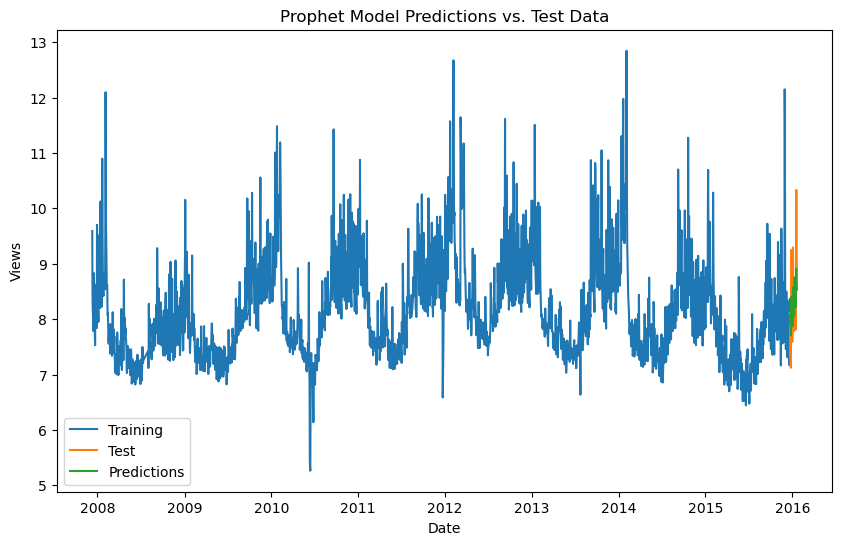

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Training')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Prophet Model Predictions vs. Test Data')
plt.show()

The chart above shows that the predictions in fact were a lot better then ARIMA's. Instead of a horizontal line, the predictions show a pattern similar to the test data. 

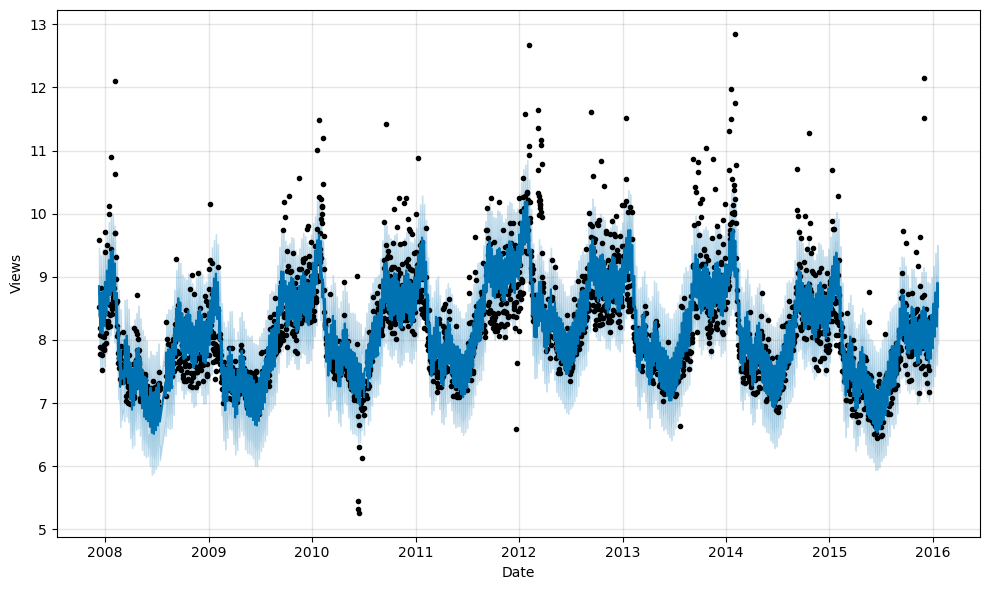

In [35]:
model.plot(forecast, xlabel = 'Date', ylabel = 'Views');

The chart above shows the real data (dots), compared to the predictions. 

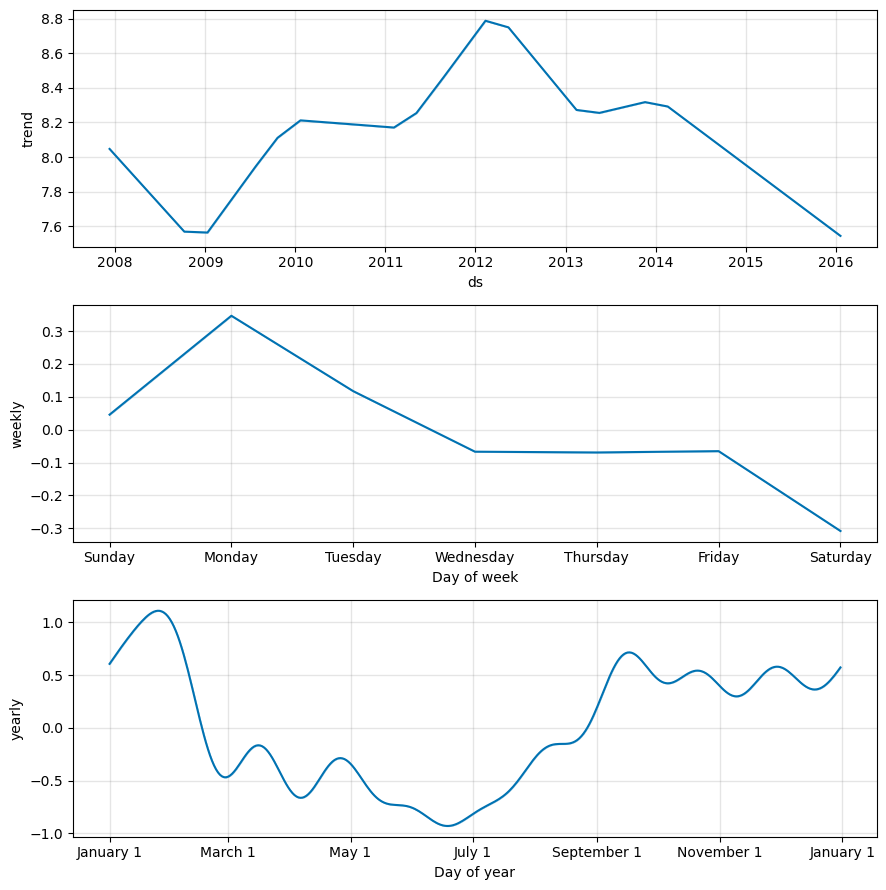

In [36]:
model.plot_components(forecast);

According to the charts above, it's possible to understand that there was an upward trend of views on 2012, followed by a downward trend until 2016, the day with the higher number of views is Monday, and February is the month with the higher number of views.

The next charts are similar to the previous, but they're dynamic. 

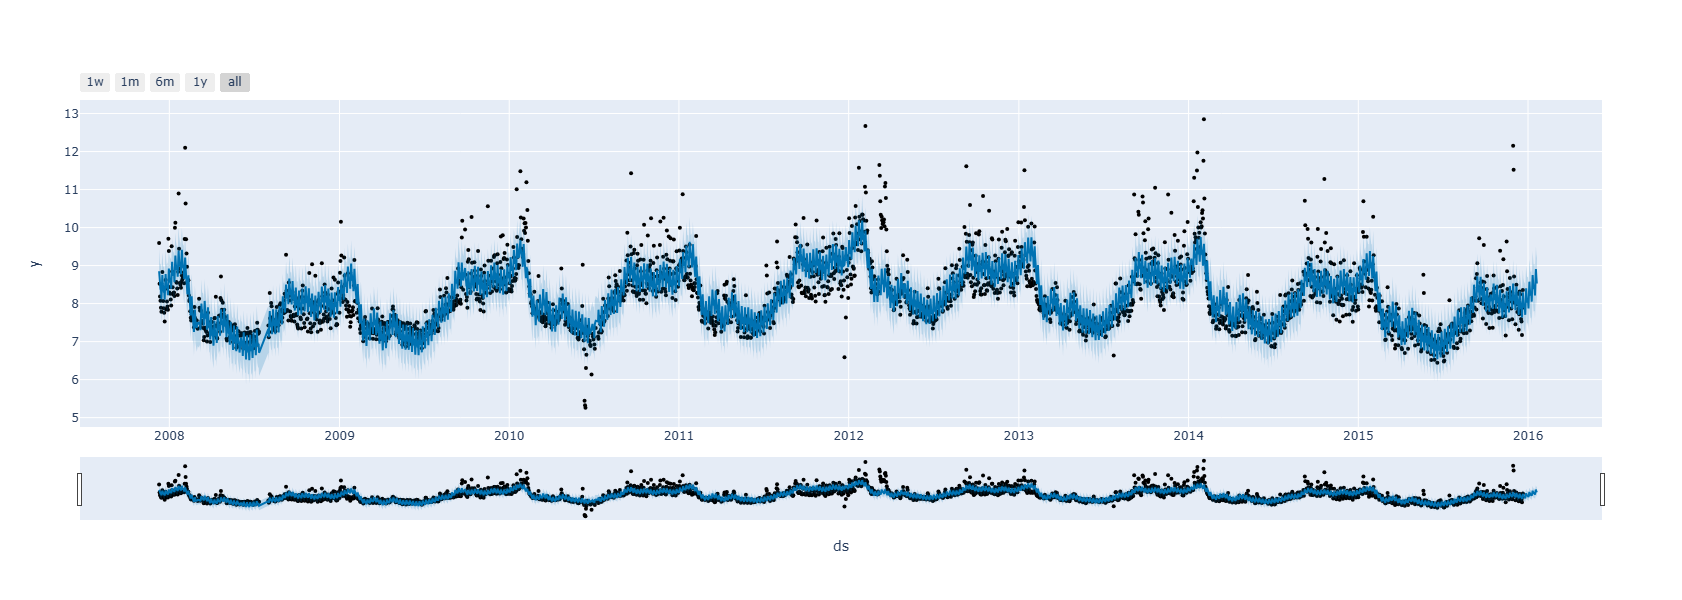

In [37]:
plot_plotly(model, forecast)

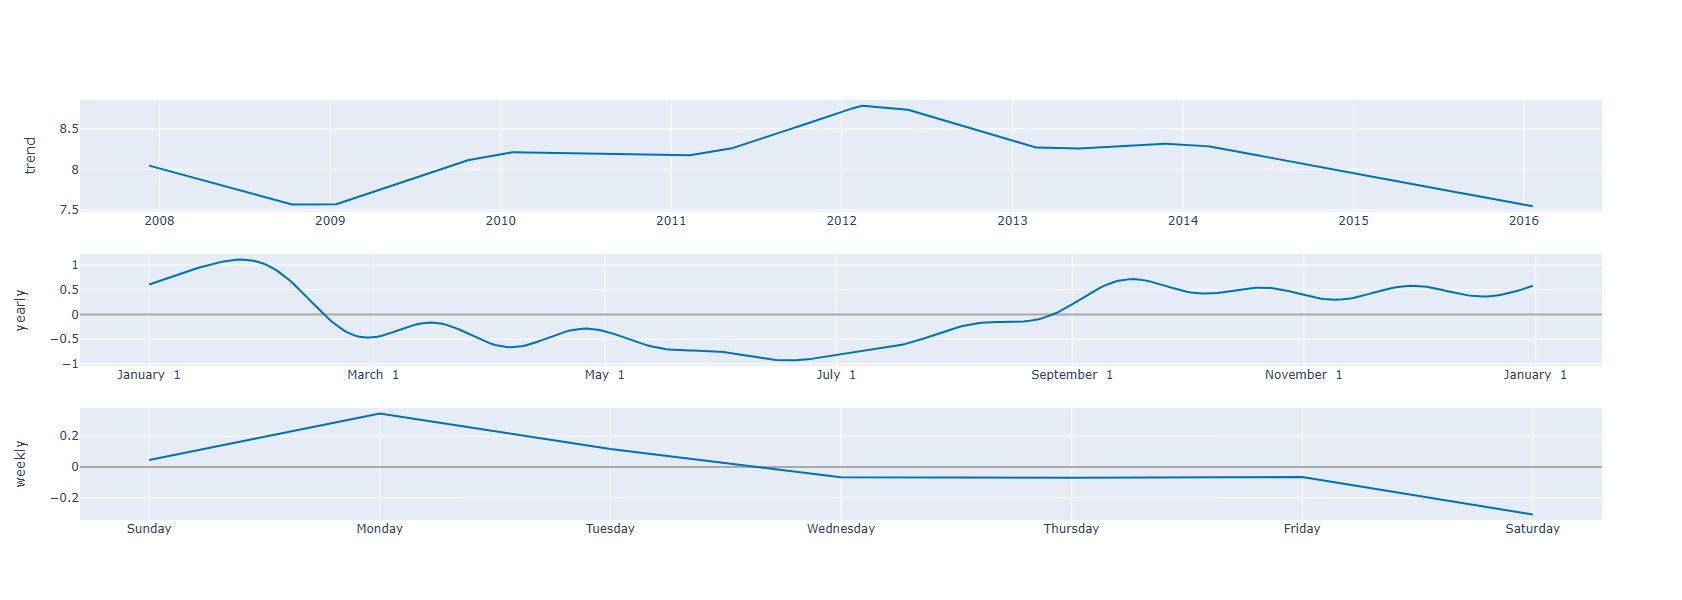

In [38]:
plot_components_plotly(model, forecast)